# UMAP on the lung cancer dataset of Zilionis

In [8]:

%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=6
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import umap
from firelight.visualizers.colorization import get_distinct_colors
from matplotlib.colors import ListedColormap
import pickle
import matplotlib.lines as mlines
import matplotlib
from umap.my_plot import plot_all_losses, hists_from_graph_embd
from umap.my_utils import filter_graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=6


In [9]:
dir_path = "../data/zilionis_cancer"
fig_path = "../figures"
seed = 0



In [10]:
# load the data
pca306 = pd.read_csv(os.path.join(dir_path,
                              "cancer_qc_final.txt"),
                     sep='\t',
                     header=None)
pca306.shape

(48969, 306)

In [11]:
meta = pd.read_csv(os.path.join(dir_path,
                              "cancer_qc_final_metadata.txt"),
                   sep="\t",
                   header=0)

cell_types = meta["Major cell type"].to_numpy()

cell_types = np.array([cell_type[1:] for cell_type in cell_types])

labels = np.zeros(len(cell_types)).astype(int)
name_to_label = {}
for i, phase in enumerate(np.unique(cell_types)):
    name_to_label[phase] = i
    labels[cell_types==phase] = i
np.random.seed(seed)
colors = get_distinct_colors(len(name_to_label))
cmap = ListedColormap(colors)
np.random.shuffle(colors)

In [12]:
try:
    with open(os.path.join(dir_path, f"umapperns_after_seed_{seed}.pkl"), "rb") as file:
        umapperns_after = pickle.load(file)
        embd_after = umapperns_after.embedding_
except FileNotFoundError:
    umapperns_after = umap.UMAP(metric="cosine",
                                  n_neighbors=30,
                                  n_epochs=750,
                                  log_losses="after",
                                  random_state=seed,
                                  verbose=True)
    embd_after = umapperns_after.fit_transform(pca306)
    with open(os.path.join(dir_path, f"umapperns_after_seed_{seed}.pkl"), "wb") as file:
        pickle.dump(umapperns_after, file, pickle.HIGHEST_PROTOCOL)


Tue Oct 19 10:44:22 2021 Building and compiling search function


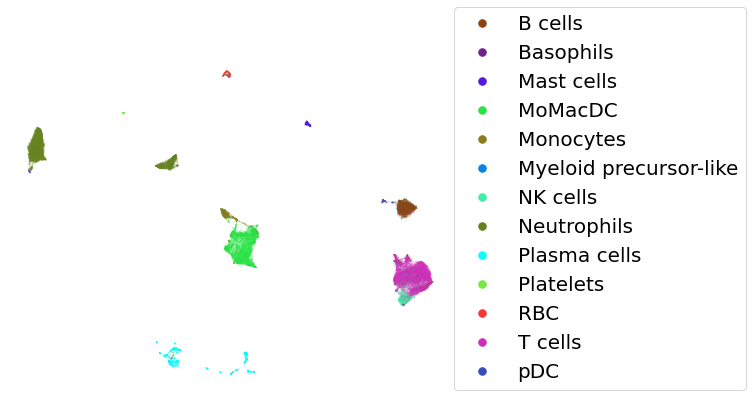

In [14]:
plt.figure(figsize=(8,8))
scatter = plt.scatter(-embd_after[:,1],
                      -embd_after[:,0],
                      c=labels,
                      s=0.01,
                      alpha=1.0,
                      cmap=cmap)
plt.axis("off")
plt.gca().set_aspect("equal")

# dummy dots for legend
dots = []
for i in range(len(np.unique(cell_types))):
    dot = mlines.Line2D([], [], color=colors[i], marker='.', linestyle="none",
                          markersize=15, label=np.unique(cell_types)[i])
    dots.append(dot)
plt.legend(handles=dots, prop={'size': 20}, loc=(1,0))


plt.savefig(os.path.join(fig_path, f"lung_cancer_after_seed_{seed}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300)


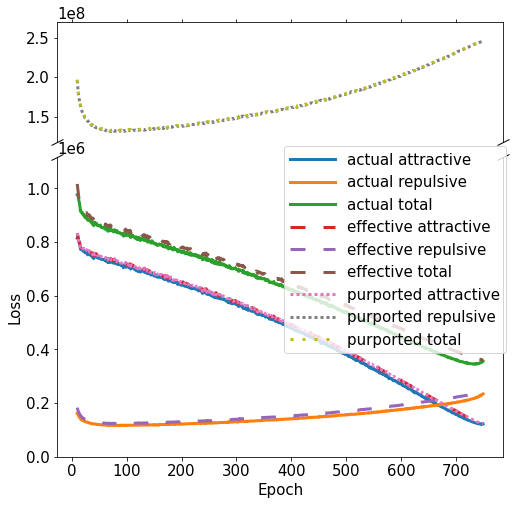

In [7]:
start=10 # omit early epochs where UMAP's sampling approximation is poor
matplotlib.rcParams.update({'font.size': 15})
fig_losses_after = plot_all_losses(umapperns_after.aux_data,start=start)
fig_losses_after.savefig(os.path.join(fig_path, f"lung_cancer_after_losses_{start}_seed_{seed}.png"),
                         bbox_inches = 'tight',
                         pad_inches = 0,
                         dpi=300)
